# Multiple Linear Regression Step by Step

The following script outlines the application of the Multiple Linear Regression technique step by step and verifies if the obtained outputs correspond to the results from the [statsmodel](https://www.statsmodels.org/) library.

# Implementation

- Check the dataset .

- Descriptive Statistics.

- Adjust the model equation using the least squares method.

- Calculate the root mean squared error (or R²) to determine if the dependent variable can be predicted by the parameters used.

- Use the F-statistic value to check if at least one of the independent variables is statistically significant.

- Check the statistical significance of each independent variable individually (and drop columns that are not significant).

- Test the normality of the residuals

- Compare the results.

## Checking the Dataset

In [1]:
# Libraries needed
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set()
warnings.filterwarnings("ignore")

In [2]:
# Check train Data
df_adver = pd.read_csv('Data/advertising.csv', index_col=0)
df_adver.head(5)

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [3]:
# Checking null values
df_adver.isna().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [4]:
# Checking parameters types
df_adver.dtypes

TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

## Descriptive Statistics

In [5]:
# Descriptive statistics
df_adver.describe().T.round(2).drop('count',1)

,mean,std,min,25%,50%,75%,max
TV,146.26,84.63,4.1,74.80,148.50,218.22,296.4
Radio,23.44,14.86,0.0,10.02,23.95,36.58,49.6
Newspaper,30.91,21.80,0.9,12.95,26.30,45.18,114.0
Sales,15.17,5.26,3.2,11.00,15.95,19.15,27.0


Apparently there's no outliers on the Dataset that could harm the model results. There's no null values either.

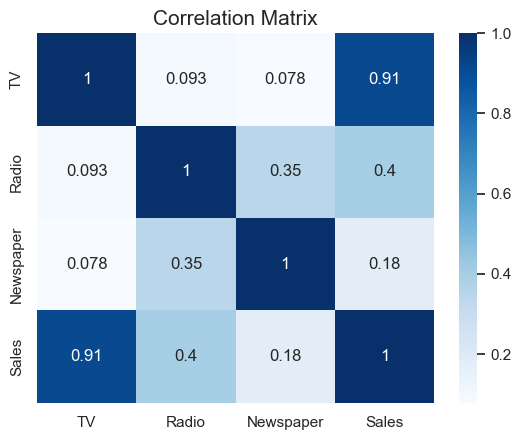

In [6]:
# Checking Correlations
sns.heatmap(df_adver.corr(), annot=True, cmap="Blues")
plt.title('Correlation Matrix', size=15);

All the other parameters have a positive correlation with 'Sales', specially 'TV'.For a better understanding of the data, it is important to observe scatter plots between pairs of variables and their histograms.

<Figure size 1500x1000 with 0 Axes>

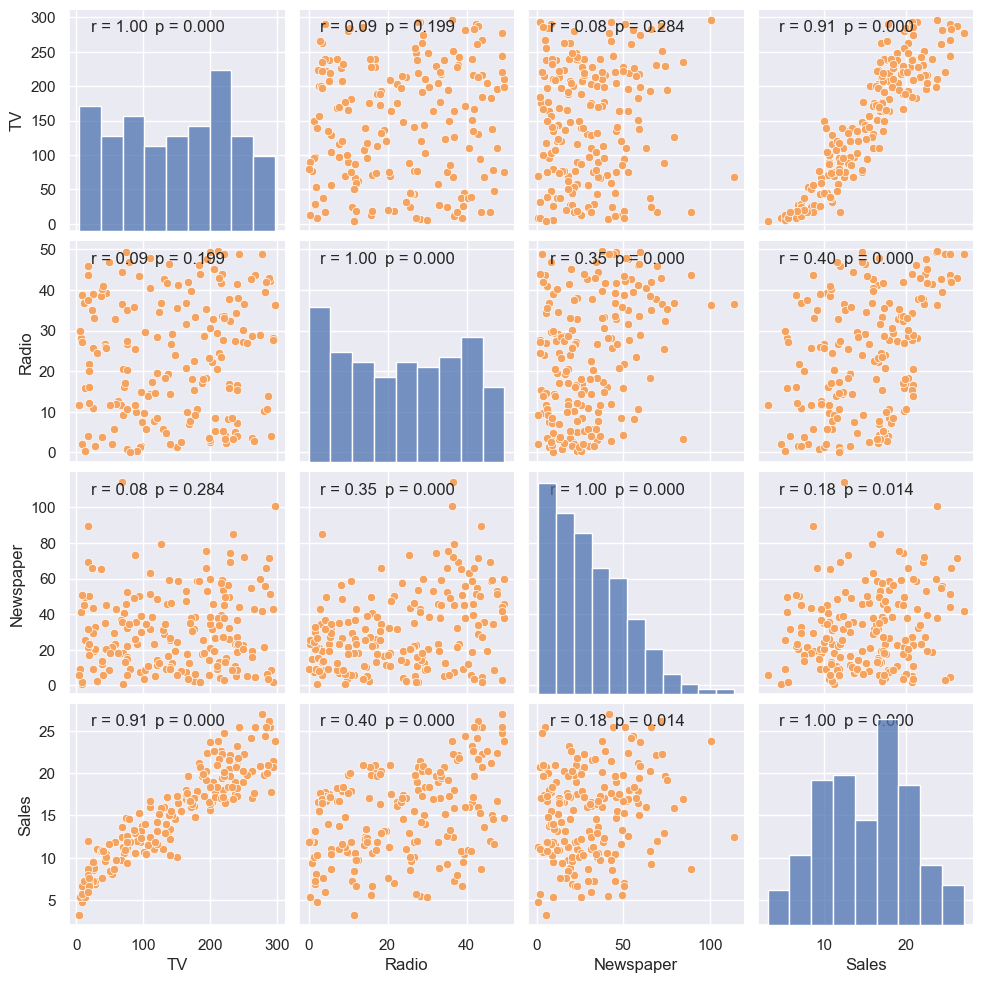

In [7]:
# Plotting Histograms and Scatter Graphs
def corrfunc(x, y, **kws):
    (r, p) = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

plt.figure(figsize=(15,10))
graph = sns.pairplot(df_adver, plot_kws={"color": "sandybrown"})
graph.map(corrfunc)
plt.show();

It's noticed by the scatter plots that 'TV' has a bigger correlation with the sales than the other variables.

## Adjusting the model

The method of least squares involves minimizing the sum of the squared differences between the observed data points and the predicted values from a linear model. The covariation between two variables is a measure of how they vary together, and is closely related to the slope of the regression line in a linear model. Specifically, the slope of the regression line is equal to the covariance of the two variables divided by the variance of the independent variable.

In [8]:
# Covariance Matrix
df_cov = pd.DataFrame(index = df_adver.columns[:-1], columns = df_adver.columns)
for idx in df_cov.index:
    for col in df_cov.columns:
        df_cov[col].loc[idx] = np.cov(np.array(df_adver[idx]), np.array(df_adver[col]))[0][1]

In [9]:
# Separating A and b
A = df_cov.iloc[0:3,0:3].values.astype(float)
b = df_cov['Sales'].values.astype(float)

coef = np.linalg.solve(A,b)

intercept = df_adver.mean()[len(df_adver.mean())-1]
for i in range(0, len(df_adver.mean())-1):
    intercept -= df_adver.mean()[i] * coef[i]
    
print(f'The equation is: yi = {round(intercept,4)} + ({round(coef[0],4)} * x1) + ({round(coef[1],4)} * x2) + ({round(coef[2],7)} * x3)')

The equation is: yi = 4.5204 + (0.0548 * x1) + (0.1121 * x2) + (-6.45e-05 * x3)


## R-squared

Tthe fitted value of the dependent variable is equal to the intercept plus the sum of the products of the coefficients and independent variables.

In [10]:
# Obtaining the fitted values
df_adver['fitted_Sales'] = intercept
for i in range (0, len(df_adver.columns)-2):
    df_adver['fitted_Sales'] += df_adver.iloc[:,i]*coef[i]
df_adver.head(5)

,TV,Radio,Newspaper,Sales,fitted_Sales
0,230.1,37.8,69.2,22.1,21.371518
1,44.5,39.3,45.1,10.4,11.363536
2,17.2,45.9,69.3,12.0,10.604833
3,151.5,41.3,58.5,16.5,17.454413
4,180.8,10.8,58.4,17.9,15.641904


In [11]:
# Getting R²
residuals = df_adver['fitted_Sales'] - df_adver['Sales']
soma_quad_fitted_med = ((df_adver['fitted_Sales']-df_adver['Sales'].mean())**2).sum()
soma_quad_fitted_real = (residuals**2).sum()
R = soma_quad_fitted_med / (soma_quad_fitted_med + soma_quad_fitted_real)
print(f'R²: {round(R,4)}')

R²: 0.931


An R² value of 0.93 means that 93% of the variability in the dependent variable (the variable being predicted) is explained by the independent variables included in the model.

Even with a high R² value, some other statistical tests should be performed to confirm that the model is well-fitted.

## F and T-Test

The F-test checks whether at least one of the coefficients is statistically significant for the model (at a 95% confidence level).

In [12]:
# F-Test
dof1 = len(df_adver.columns) - 2
dof2 = len(df_adver) - dof1 -1
f_stat = ((soma_quad_fitted_med/dof1)/(soma_quad_fitted_real/dof2))
    
# P-value for F-Test
pvalf = 1-stats.f.cdf(f_stat, dof1, dof2)
print(f'F-statistic: {round(f_stat, 4)}, p-value: {round(pvalf, 4)}.')
    
# Checking significance
if pvalf < 0.05:
    print('At least one 𝛽 is significant.')
else:
    print('There are no significant 𝛽.')

F-statistic: 836.6136, p-value: 0.0.
At least one 𝛽 is significant.


Assuming significant variables in the model based on the p-value of the F-test, the T-test is applied to each of the coefficients (including the intercept) to see if any variable is not significant and can be removed from the model.


In [13]:
# Creating a Matrix that contains de dependent values and a column of 1
X_ = np.concatenate((np.array([1 for x in range(0, len(df_adver))]).reshape(-1,1), df_adver[['TV', 'Radio', 'Newspaper']].values), axis=1)

In [14]:
# Sigma squared hat (3 cause the model has 3 predictory variables)
sigma_squared_hat = soma_quad_fitted_real / (len(df_adver) - df_adver.shape[1])
var_beta_hat = np.linalg.inv(X_.T @ X_) * sigma_squared_hat

In [15]:
# Testing the intercept significance
estat_t_alpha = intercept/(var_beta_hat[0, 0] ** 0.5 )  
pvalt = (1-stats.t.cdf(estat_t_alpha, dof2))*2
print(f'T statistic (α): {round(estat_t_alpha,4)}, p-value: {round(pvalt, 4)}.')
if pvalt < 0.05:
    print(f'The intercept is statisticly different than 0.\n')
else:
    print(f'The intercept is statisticly equal 0.\n') 

# Testing the predictory variables significance
for i in range(0,3):
    estat_t_beta = coef[i]/(var_beta_hat[i+1, i+1] ** 0.5 )  
    pvalt = stats.t.cdf(-abs(estat_t_beta), dof2) * 2
        
    print(f'T statistic (𝛽{i}): {round(estat_t_beta,4)}, p-value: {round(pvalt, 4)}.')
    if pvalt < 0.05:
        print(f'Coeficient 𝛽{i} ({df_adver.columns[i]}) is statisticly different than 0.\n')
    else:
        print(f'Coeficient 𝛽{i} ({df_adver.columns[i]}) is statisticly equal 0.\n')

T statistic (α): 17.1559, p-value: 0.0.
The intercept is statisticly different than 0.

T statistic (𝛽0): 45.4339, p-value: 0.0.
Coeficient 𝛽0 (TV) is statisticly different than 0.

T statistic (𝛽1): 15.3474, p-value: 0.0.
Coeficient 𝛽1 (Radio) is statisticly different than 0.

T statistic (𝛽2): -0.013, p-value: 0.9897.
Coeficient 𝛽2 (Newspaper) is statisticly equal 0.



As can be observed, the p-value of the t-test corresponding to the 'Newspaper' variable is -0.013, therefore, this variable is not significant for the model construction and can be disregarded.

All of the processes needs to be repeated, excluding the variable.


## Repeating the Proccess considering just Statistically Significant variables

In [16]:
# Check train Data
df_adver = pd.read_csv('Data/advertising.csv', index_col=0)
df_adver = df_adver.drop('Newspaper', 1)
df_adver.head(5)

,TV,Radio,Sales
0,230.1,37.8,22.1
1,44.5,39.3,10.4
2,17.2,45.9,12.0
3,151.5,41.3,16.5
4,180.8,10.8,17.9


In [17]:
# Covariance Matrix
df_cov = pd.DataFrame(index = df_adver.columns[:-1], columns = df_adver.columns)
for idx in df_cov.index:
    for col in df_cov.columns:
        df_cov[col].loc[idx] = np.cov(np.array(df_adver[idx]), np.array(df_adver[col]))[0][1]

In [18]:
# Separating A and b
A = df_cov.iloc[0:2,0:2].values.astype(float)
b = df_cov['Sales'].values.astype(float)

coef = np.linalg.solve(A,b)

intercept = df_adver.mean()[len(df_adver.mean())-1]
for i in range(0, len(df_adver.mean())-1):
    intercept -= df_adver.mean()[i] * coef[i]
    
print(f'The equation is: yi = {round(intercept,4)} + ({round(coef[0],4)} * x1) + ({round(coef[1],4)} * x2)')

The equation is: yi = 4.5193 + (0.0548 * x1) + (0.1121 * x2)


In [19]:
# Obtaining the fitted values
df_adver['fitted_Sales'] = intercept
for i in range (0, len(df_adver.columns)-2):
    df_adver['fitted_Sales'] += df_adver.iloc[:,i]*coef[i]
df_adver.head(5)

,TV,Radio,Sales,fitted_Sales
0,230.1,37.8,22.1,21.373458
1,44.5,39.3,10.4,11.364016
2,17.2,45.9,12.0,10.606680
3,151.5,41.3,16.5,17.455609
4,180.8,10.8,17.9,15.644059


In [20]:
# Getting R²
residuals = df_adver['fitted_Sales'] - df_adver['Sales']
soma_quad_fitted_med = ((df_adver['fitted_Sales']-df_adver['Sales'].mean())**2).sum()
soma_quad_fitted_real = (residuals**2).sum()
R = soma_quad_fitted_med / (soma_quad_fitted_med + soma_quad_fitted_real)
print(f'R²: {round(R,4)}')

R²: 0.931


It is interesting to note that despite the removal of the variable, the R² value of the model did not change. However, regardless of this value, the model will be better adjusted without the presence of this variable.

In [21]:
# F-Test
dof1 = len(df_adver.columns)-2
dof2 = len(df_adver) - dof1 -1
f_stat = ((soma_quad_fitted_med/dof1)/(soma_quad_fitted_real/dof2))
    
# P-value for F-Test
pvalf = 1-stats.f.cdf(f_stat, dof1, dof2)
print(f'F-statistic: {round(f_stat, 4)}, p-value: {round(pvalf, 4)}.')
    
# Checking significance
if pvalf < 0.05:
    print('At least one 𝛽 is significant.')
else:
    print('There are no significant 𝛽.')

F-statistic: 1261.6661, p-value: 0.0.
At least one 𝛽 is significant.


In [22]:
# Sigma squared hat (3 cause the model has 3 predictory variables)
sigma_squared_hat = soma_quad_fitted_real / (len(df_adver) - df_adver.shape[1])
var_beta_hat = np.linalg.inv(X_.T @ X_) * sigma_squared_hat

In [23]:
# Testing the intercept significance
estat_t_alpha = intercept/(var_beta_hat[0, 0] ** 0.5 )  
pvalt = (1-stats.t.cdf(estat_t_alpha, dof2))*2
print(f'T statistic (α): {round(estat_t_alpha,4)}, p-value: {round(pvalt, 4)}.')
if pvalt < 0.05:
    print(f'The intercept is statisticly different than 0.\n')
else:
    print(f'The intercept is statisticly equal 0.\n') 

# Testing the predictory variables significance
for i in range(0,2):
    estat_t_beta = coef[i]/(var_beta_hat[i+1, i+1] ** 0.5 )  
    pvalt = (1-stats.t.cdf(estat_t_beta, dof2))*2
        
    print(f'T statistic (𝛽{i}): {round(estat_t_beta,4)}, p-value: {round(pvalt, 4)}.')
    if pvalt < 0.05:
        print(f'Coeficient 𝛽{i} ({df_adver.columns[i]}) is statisticly different than 0.\n')
    else:
        print(f'Coeficient 𝛽{i} ({df_adver.columns[i]}) is statisticly equal 0.\n')

T statistic (α): 17.1979, p-value: 0.0.
The intercept is statisticly different than 0.

T statistic (𝛽0): 45.5559, p-value: 0.0.
Coeficient 𝛽0 (TV) is statisticly different than 0.

T statistic (𝛽1): 15.3843, p-value: 0.0.
Coeficient 𝛽1 (Radio) is statisticly different than 0.



## Checking the Residual Normality

If the residuals are not normally distributed, this can indicate the presence of some form of bias or nonlinearity in the model. This can lead to inaccurate predictions and reduced model performance. Therefore, it is important to check the normality of the residuals as part of the model diagnostic process.

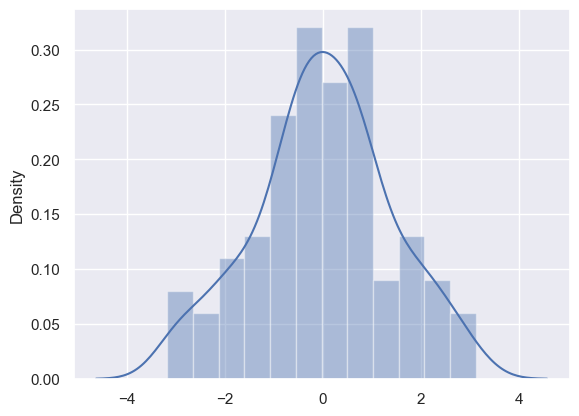

In [24]:
# Plotting a Histogram
sns.distplot(residuals);

A histogram can be a useful tool to observe the normality of the residuals, but to be more certain, the Shapiro-Wilk test is often used. This statistical test measures the discrepancy between the observed distribution of data and the expected distribution under normality, and provides a p-value to assess the normality of the data.

If the Shapiro test returns a p-value greater than 0.05, this indicates that there is not enough evidence to reject the null hypothesis of normality. In other words, we can conclude that the data follows a normal distribution at a significance level of 5% (or lower, depending on the exact p-value obtained).

In [25]:
# Shapiro Test
stats.shapiro(residuals)

ShapiroResult(statistic=0.9884517192840576, pvalue=0.12589530646800995)

The Linear Regression Model described by the variables 'Radio' and 'TV' is completed. It explains the behavior of the 'Sales' variable by 93% and its equation is:

${Sales}_i = {4.5193} + {TV}_{i} * {0.0548} + {Radio}_{i} * {0.1121}$

The significance of its variables could be observed, as well as the normality of the obtained residuals.

## Comparing the results

Now the results gotten on the step-by-step implementation will be compared to the results from sklearn library.

Firstly, we will compare the results of the model without the exclusion of the 'Newspaper' variable, which had an intercept of 4.5204 and coefficients (0.0548, 0.1121, and -6.45e-05) with an R² of 93%.

In [26]:
# Importing LinearRegression from sklearn
import statsmodels.api as sm

In [27]:
# Check Data
df_adver_comp1 = pd.read_csv('Data/advertising.csv', index_col=0)

In [28]:
# Applying the Dataframe on the model (the constant needs to be added on X for considering the intercept)
x_v = sm.add_constant(df_adver_comp1.drop('Sales', 1).values)
y_v = df_adver_comp1['Sales'].values

In [29]:
# Creating the model
linear_model = sm.OLS(y_v, x_v).fit()

In [30]:
# Model parameters
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     836.6
Date:                Thu, 13 Apr 2023   Prob (F-statistic):          1.08e-107
Time:                        17:24:42   Log-Likelihood:                -330.50
No. Observations:                 190   AIC:                             669.0
Df Residuals:                     186   BIC:                             682.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5204      0.263     17.202      0.000       4.002       5.039
x1             0.0548      0.001     45.557      0.000       0.052       0.057
x2             0.1121      0.007     15.389      0.000       0.098       0.126
x3         -6.447e-05      0.005     -0.013      0.990      -0.010       0.010
==============================================================================
Omnibus:                        0.624   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.732   Jarque-Bera (JB):                0.759
Skew:                           0.099   Prob(JB):                        0.684
Kurtosis:                       2.762   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All the results match perfectly, even the p-value which indicated that the Newspapper column is not statistically significant. Now we will compare the results of a new model, without this variable.

In [31]:
# Dropping Newspaper
df_adver_comp1 = df_adver_comp1.drop('Newspaper', 1)

In [32]:
# Applying the Dataframe on the model
x_v = sm.add_constant(df_adver_comp1.drop('Sales', 1).values)
y_v = df_adver_comp1['Sales'].values

In [33]:
# Creating the model
linear_model2 = sm.OLS(y_v, x_v).fit()

In [34]:
# Model Parameters
linear_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     1262.
Date:                Thu, 13 Apr 2023   Prob (F-statistic):          2.69e-109
Time:                        17:24:42   Log-Likelihood:                -330.50
No. Observations:                 190   AIC:                             667.0
Df Residuals:                     187   BIC:                             676.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5193      0.248     18.256      0.000       4.031       5.008
x1             0.0548      0.001     45.733      0.000       0.052       0.057
x2             0.1121      0.007     16.414      0.000       0.099       0.126
==============================================================================
Omnibus:                        0.628   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.730   Jarque-Bera (JB):                0.763
Skew:                           0.099   Prob(JB):                        0.683
Kurtosis:                       2.762   Cond. No.                         418.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results obtained from the sklearn library are again identical to those reproduced in the step-by-step process for building the model.

## Applying MultipleLinearRegression

Once we observed that the results obtained step by step coincided with the results from the statsmodel library, a second comparison will be made, this time with the MultipleLinearRegression function present in the MLRFunction.ipynb notebook.

In [36]:
# Check Data
df_adver_comp2 = pd.read_csv('Data/advertising.csv', index_col=0)

In [39]:
# Loading the Notebook
%run MLRFunction.ipynb 

In [40]:
# Applying the function (opt=True for excluding non statistically significant coefficients)
MultipleLinearRegression(df_adver_comp2, opt=True)

R²: 0.931,	The Dataframe has 190 registers and 4 columns.

F-statistic: 836.6136,	p-value (F-statistic): 0.0
______________________________________________________________________

           Estimate Std. Error T statistic   P value Sig. at 0.05
intercept  4.520446   0.262783   17.202212       0.0            y
TV         0.054837   0.001204   45.556559       0.0            y
Radio      0.112106   0.007285   15.388786       0.0            y
Newspaper -0.000064   0.004959      -0.013  0.989642            n

______________________________________________________________________
Excluding columns not statistically significants.
Excluded column: Newspaper
______________________________________________________________________
######################################################################
			Iteration number 1
n#####################################################################
______________________________________________________________________

R²: 0.931,	The Dataframe has 190 

,TV,Radio,Sales,fitted_values
0,230.1,37.8,22.1,21.373458
1,44.5,39.3,10.4,11.364016
2,17.2,45.9,12.0,10.606680
3,151.5,41.3,16.5,17.455609
4,180.8,10.8,17.9,15.644059
...,...,...,...,...
185,149.7,35.6,17.3,16.718085
186,38.2,3.7,7.6,7.028730
187,177.0,9.3,14.8,15.267572
188,283.6,42.0,25.5,24.777890
